In [ ]:
!pip install ray
!pip install pytorch_lightning
!pip install darts

In [ ]:
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping
from ray import tune
from ray.tune import CLIReporter
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection

from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
from darts import TimeSeries

In [ ]:
def train_model(model_args, callbacks, train, val):
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), MeanAbsoluteError()])
    # Create the model using model_args from Ray Tune
    model = NBEATSModel(
        input_chunk_length=24,
        output_chunk_length=12,
        n_epochs=50,
        torch_metrics=torch_metrics,
        pl_trainer_kwargs={"callbacks": callbacks, "enable_progress_bar": False},
        **model_args)

    model.fit(
        series=train,
        val_series=val,
    )

Load Data / Spilt Data

In [ ]:
df = pd.read_csv('/content/EDvisitfile.csv')

series = TimeSeries.from_dataframe(df, 'date', 'No')
train_scaler = Scaler()
series_scaled = train_scaler.fit_transform(series)

#Spilt data
train_proportion = 0.6
val_proportion = 0.3

# Calculate the split indices
train_end = int(len(series) * train_proportion)
val_end = train_end + int(len(series) * val_proportion)

# Split the list
train = series[:train_end]
val = series[train_end:val_end]
test = series[val_end:]
train

Hypertuning

In [ ]:
my_stopper = EarlyStopping(
    monitor="val_MeanAbsolutePercentageError",
    patience=5,
    min_delta=0.05,
    mode='min',
)


In [ ]:
# set up ray tune callback
tune_callback = TuneReportCallback(
    {
        "loss": "val_loss",
        "MAPE": "val_MeanAbsolutePercentageError",
    },
    on="validation_end",
)

# define the hyperparameter space
config = {
    "batch_size": tune.choice([16, 32, 64, 128]),
    "num_blocks": tune.choice([1, 2, 3, 4, 5]),
    "dropout": tune.uniform(0, 0.1),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["loss", "MAPE", "training_iteration"],
)

In [ ]:
num_samples = 10

scheduler = ASHAScheduler(max_t=1000, grace_period=3, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(
    train_model, callbacks=[my_stopper, tune_callback], train=train, val=val,
)

# optimize hyperparameters by minimizing the MAPE on the validation set
analysis = tune.run(
    train_fn_with_parameters,
    #resources_per_trial=resources_per_trial,
    # Using a metric instead of loss allows for
    # comparison between different likelihood or loss functions.
    metric="MAPE",  # any value in TuneReportCallback.
    mode="min",
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter,
    name="tune_darts",
)

print("Best hyperparameters found were: ", analysis.best_config)

2024-01-20 16:54:44,514	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-01-20 16:54:44,526	WARNING tune.py:916 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+----------------------------------------------------------+
| Configuration for experiment     tune_darts              |
+----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator   |
| Scheduler                        AsyncHyperBandScheduler |
| Number of trials                 10                      |
+----------------------------------------------------------+

View detailed results here: /root/ray_results/tune_darts
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/tune_darts`

Trial status: 10 PENDING
Current time: 2024-01-20 16:54:44. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------+
| Trial name                status       batch_size     num_blocks       dropout |
+--------------------------------------------------------------------------------+
| train_model_9ca6f_00000   PENDING   

(train_model pid=25858) GPU available: False, used: False
(train_model pid=25858) TPU available: False, using: 0 TPU cores
(train_model pid=25858) IPU available: False, using: 0 IPUs
(train_model pid=25858) HPU available: False, using: 0 HPUs
(train_model pid=25858) 
(train_model pid=25858)   | Name          | Type             | Params
(train_model pid=25858) ---------------------------------------------------
(train_model pid=25858) 0 | criterion     | MSELoss          | 0     
(train_model pid=25858) 1 | train_metrics | MetricCollection | 0     
(train_model pid=25858) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=25858) 3 | stacks        | ModuleList       | 6.2 M 
(train_model pid=25858) ---------------------------------------------------
(train_model pid=25858) 6.2 M     Trainable params
(train_model pid=25858) 1.4 K     Non-trainable params
(train_model pid=25858) 6.2 M     Total params
(train_model pid=25858) 24.787    Total estimated model params size (MB)
(tra


Trial status: 2 RUNNING | 8 PENDING
Current time: 2024-01-20 16:55:14. Total running time: 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------+
| Trial name                status       batch_size     num_blocks       dropout |
+--------------------------------------------------------------------------------+
| train_model_9ca6f_00000   RUNNING              16              1   0.0593578   |
| train_model_9ca6f_00001   RUNNING             128              1   0.0409839   |
| train_model_9ca6f_00002   PENDING              64              2   0.0802742   |
| train_model_9ca6f_00003   PENDING              32              4   0.094845    |
| train_model_9ca6f_00004   PENDING              32              2   0.0741104   |
| train_model_9ca6f_00005   PENDING              32              3   0.000782663 |
| train_model_9ca6f_00006   PENDING             128              2   0.0562675   |
| train_model_9ca6f_00007   P

(train_model pid=25858) GPU available: False, used: False [repeated 2x across cluster]
(train_model pid=25858) TPU available: False, using: 0 TPU cores [repeated 2x across cluster]
(train_model pid=25858) IPU available: False, using: 0 IPUs [repeated 2x across cluster]
(train_model pid=25858) HPU available: False, using: 0 HPUs [repeated 2x across cluster]
(train_model pid=25857) 
(train_model pid=25857)   | Name          | Type             | Params
(train_model pid=25857) --------------------------------------------------- [repeated 2x across cluster]
(train_model pid=25857) 0 | criterion     | MSELoss          | 0     
(train_model pid=25857) 1 | train_metrics | MetricCollection | 0     
(train_model pid=25857) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=25857) 3 | stacks        | ModuleList       | 6.2 M 
(train_model pid=25857) 6.2 M     Trainable params
(train_model pid=25857) 1.4 K     Non-trainable params
(train_model pid=25857) 6.2 M     Total params
(train_m


Trial status: 2 RUNNING | 1 TERMINATED | 7 PENDING
Current time: 2024-01-20 16:56:45. Total running time: 2min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 9ca6f_00001 with MAPE=0.07421531434130972 and params={'batch_size': 128, 'num_blocks': 1, 'dropout': 0.04098393717189091}
+------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         batch_size     num_blocks       dropout     iter     total time (s)      loss        MAPE |
+------------------------------------------------------------------------------------------------------------------------------------+
| train_model_9ca6f_00000   RUNNING                16              1   0.0593578          1            55.1103   2969.89   0.0796223 |
| train_model_9ca6f_00002   RUNNING                64              2   0.0802742                                                     |
| train_model_9ca6f_000

(train_model pid=25857) GPU available: False, used: False
(train_model pid=25857) TPU available: False, using: 0 TPU cores
(train_model pid=25857) IPU available: False, using: 0 IPUs
(train_model pid=25857) HPU available: False, using: 0 HPUs
(train_model pid=25858) --------------------------------------------------- [repeated 2x across cluster]
(train_model pid=25858) GPU available: False, used: False
(train_model pid=25858) TPU available: False, using: 0 TPU cores
(train_model pid=25858) IPU available: False, using: 0 IPUs
(train_model pid=25858) HPU available: False, using: 0 HPUs
(train_model pid=25858) 
(train_model pid=25858)   | Name          | Type             | Params
(train_model pid=25858) 0 | criterion     | MSELoss          | 0     
(train_model pid=25858) 1 | train_metrics | MetricCollection | 0     
(train_model pid=25858) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=25858) 3 | stacks        | ModuleList       | 12.4 M
(train_model pid=25858) 12.4 M    


Trial status: 3 TERMINATED | 2 RUNNING | 5 PENDING
Current time: 2024-01-20 17:00:15. Total running time: 5min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 9ca6f_00001 with MAPE=0.07421531434130972 and params={'batch_size': 128, 'num_blocks': 1, 'dropout': 0.04098393717189091}
+------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         batch_size     num_blocks       dropout     iter     total time (s)      loss        MAPE |
+------------------------------------------------------------------------------------------------------------------------------------+
| train_model_9ca6f_00003   RUNNING                32              4   0.094845                                                      |
| train_model_9ca6f_00004   RUNNING                32              2   0.0741104                                                     |
| train_model_9ca6f_00

(train_model pid=25858) GPU available: False, used: False
(train_model pid=25858) TPU available: False, using: 0 TPU cores
(train_model pid=25858) IPU available: False, using: 0 IPUs
(train_model pid=25858) HPU available: False, using: 0 HPUs
(train_model pid=25857) --------------------------------------------------- [repeated 4x across cluster]
(train_model pid=25857) 
(train_model pid=25857)   | Name          | Type             | Params
(train_model pid=25857) 0 | criterion     | MSELoss          | 0     
(train_model pid=25857) 1 | train_metrics | MetricCollection | 0     
(train_model pid=25857) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=25857) 3 | stacks        | ModuleList       | 24.8 M
(train_model pid=25857) 24.8 M    Trainable params
(train_model pid=25857) 1.4 K     Non-trainable params
(train_model pid=25857) 24.8 M    Total params
(train_model pid=25857) 99.150    Total estimated model params size (MB)
(train_model pid=25857) /usr/local/lib/python3.10/d


Trial status: 4 TERMINATED | 2 RUNNING | 4 PENDING
Current time: 2024-01-20 17:03:15. Total running time: 8min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 9ca6f_00001 with MAPE=0.07421531434130972 and params={'batch_size': 128, 'num_blocks': 1, 'dropout': 0.04098393717189091}
+------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         batch_size     num_blocks       dropout     iter     total time (s)      loss        MAPE |
+------------------------------------------------------------------------------------------------------------------------------------+
| train_model_9ca6f_00003   RUNNING                32              4   0.094845           1           110.102    3414.03   0.0939533 |
| train_model_9ca6f_00005   RUNNING                32              3   0.000782663                                                   |
| train_model_9ca6f_00

(train_model pid=25857) GPU available: False, used: False
(train_model pid=25857) TPU available: False, using: 0 TPU cores
(train_model pid=25857) IPU available: False, using: 0 IPUs
(train_model pid=25857) HPU available: False, using: 0 HPUs
(train_model pid=25858) --------------------------------------------------- [repeated 2x across cluster]
(train_model pid=25857) 
(train_model pid=25857)   | Name          | Type             | Params
(train_model pid=25857) 0 | criterion     | MSELoss          | 0     
(train_model pid=25857) 1 | train_metrics | MetricCollection | 0     
(train_model pid=25857) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=25857) 3 | stacks        | ModuleList       | 12.4 M
(train_model pid=25857) 12.4 M    Trainable params
(train_model pid=25857) 1.4 K     Non-trainable params
(train_model pid=25857) 12.4 M    Total params
(train_model pid=25857) 49.575    Total estimated model params size (MB)
(train_model pid=25857) /usr/local/lib/python3.10/d


Trial train_model_9ca6f_00005 finished iteration 2 at 2024-01-20 17:05:30. Total running time: 10min 45s
+--------------------------------------------------+
| Trial train_model_9ca6f_00005 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         77.3951 |
| time_total_s                             164.044 |
| training_iteration                             2 |
| MAPE                                     0.07315 |
| loss                                     2576.34 |
+--------------------------------------------------+

Trial train_model_9ca6f_00006 finished iteration 1 at 2024-01-20 17:05:43. Total running time: 10min 58s
+--------------------------------------------------+
| Trial train_model_9ca6f_00006 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         27.

(train_model pid=25857) GPU available: False, used: False
(train_model pid=25857) TPU available: False, using: 0 TPU cores
(train_model pid=25857) IPU available: False, using: 0 IPUs
(train_model pid=25857) HPU available: False, using: 0 HPUs
(train_model pid=25857) --------------------------------------------------- [repeated 2x across cluster]
(train_model pid=25857) 
(train_model pid=25857)   | Name          | Type             | Params
(train_model pid=25857) 0 | criterion     | MSELoss          | 0     
(train_model pid=25857) 1 | train_metrics | MetricCollection | 0     
(train_model pid=25857) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=25857) 3 | stacks        | ModuleList       | 6.2 M 
(train_model pid=25857) 6.2 M     Trainable params
(train_model pid=25857) 1.4 K     Non-trainable params
(train_model pid=25857) 6.2 M     Total params
(train_model pid=25857) 24.787    Total estimated model params size (MB)
(train_model pid=25857) /usr/local/lib/python3.10/d


Trial train_model_9ca6f_00005 finished iteration 4 at 2024-01-20 17:08:07. Total running time: 13min 23s
+--------------------------------------------------+
| Trial train_model_9ca6f_00005 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         76.3825 |
| time_total_s                             321.548 |
| training_iteration                             4 |
| MAPE                                      0.0736 |
| loss                                     2363.24 |
+--------------------------------------------------+

Trial train_model_9ca6f_00007 finished iteration 1 at 2024-01-20 17:08:14. Total running time: 13min 29s
+--------------------------------------------------+
| Trial train_model_9ca6f_00007 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                          28

(train_model pid=25857) GPU available: False, used: False
(train_model pid=25857) TPU available: False, using: 0 TPU cores
(train_model pid=25857) IPU available: False, using: 0 IPUs
(train_model pid=25857) HPU available: False, using: 0 HPUs
(train_model pid=25857) --------------------------------------------------- [repeated 2x across cluster]
(train_model pid=25857) 
(train_model pid=25857)   | Name          | Type             | Params
(train_model pid=25857) 0 | criterion     | MSELoss          | 0     
(train_model pid=25857) 1 | train_metrics | MetricCollection | 0     
(train_model pid=25857) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=25857) 3 | stacks        | ModuleList       | 12.4 M
(train_model pid=25857) 12.4 M    Trainable params
(train_model pid=25857) 1.4 K     Non-trainable params
(train_model pid=25857) 12.4 M    Total params
(train_model pid=25857) 49.575    Total estimated model params size (MB)
(train_model pid=25857) /usr/local/lib/python3.10/d


Trial train_model_9ca6f_00005 finished iteration 6 at 2024-01-20 17:10:40. Total running time: 15min 55s
+--------------------------------------------------+
| Trial train_model_9ca6f_00005 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         76.1364 |
| time_total_s                             474.144 |
| training_iteration                             6 |
| MAPE                                     0.07503 |
| loss                                     2400.97 |
+--------------------------------------------------+

Trial train_model_9ca6f_00005 completed after 6 iterations at 2024-01-20 17:10:40. Total running time: 15min 56s

Trial train_model_9ca6f_00009 started with configuration:
+--------------------------------------------------+
| Trial train_model_9ca6f_00009 config             |
+--------------------------------------------------+
| batch_size                    

(train_model pid=25858) GPU available: False, used: False
(train_model pid=25858) TPU available: False, using: 0 TPU cores
(train_model pid=25858) IPU available: False, using: 0 IPUs
(train_model pid=25858) HPU available: False, using: 0 HPUs
(train_model pid=25857) --------------------------------------------------- [repeated 2x across cluster]
(train_model pid=25858) 
(train_model pid=25858)   | Name          | Type             | Params
(train_model pid=25858) 0 | criterion     | MSELoss          | 0     
(train_model pid=25858) 1 | train_metrics | MetricCollection | 0     
(train_model pid=25858) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=25858) 3 | stacks        | ModuleList       | 24.8 M
(train_model pid=25858) 24.8 M    Trainable params
(train_model pid=25858) 1.4 K     Non-trainable params
(train_model pid=25858) 24.8 M    Total params
(train_model pid=25858) 99.150    Total estimated model params size (MB)
(train_model pid=25858) /usr/local/lib/python3.10/d


Trial status: 8 TERMINATED | 2 RUNNING
Current time: 2024-01-20 17:10:46. Total running time: 16min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 9ca6f_00006 with MAPE=0.07332312494412772 and params={'batch_size': 128, 'num_blocks': 2, 'dropout': 0.05626754057815234}
+------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         batch_size     num_blocks       dropout     iter     total time (s)      loss        MAPE |
+------------------------------------------------------------------------------------------------------------------------------------+
| train_model_9ca6f_00008   RUNNING               128              2   0.0851377                                                     |
| train_model_9ca6f_00009   RUNNING                64              4   0.0318187                                                     |
| train_model_9ca6f_00000   TERMIN

After get optimal hyperparameter, train fine model

In [ ]:
!pip install torch

In [ ]:
import torch

In [ ]:
optimizer_kwargs = {
    "lr": 0.001,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 100,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 5,
    "min_delta": 1,
    "mode": "min",
}


common_model_args = {
    "input_chunk_length": 720,  # lookback window
    "output_chunk_length": 48,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    "likelihood": None,  # use a likelihood for probabilistic forecasts
    "force_reset": True,
    "batch_size": 128,
    "random_state": 42,}

model_NBEATS = NBEATSModel(
    **common_model_args,
    model_name="NBEATS1",
    save_checkpoints='/content/darts_logs/_model.pth.tar',
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    dropout=0.00646439,
    )

models = {
    "NBEATS": model_NBEATS,
}

In [ ]:
# train the models and load the model from its best state/checkpoint
for name, model in models.items():

    # early stopping needs to get reset for each model
    pl_trainer_kwargs["callbacks"] = [
        EarlyStopping(
            **early_stopping_args,
        )
    ]

    model.fit(
        series=train,
        val_series=val,
        verbose=False,
    )
    # load from checkpoint returns a new model object, we store it in the models dict
    models[name] = model.load_from_checkpoint(model_name=model.model_name, best=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
model_NBEATS.load_weights_from_checkpoint('NBEATS1')

Make prediction

In [ ]:
from darts.metrics import mae, mse, mape
import matplotlib.pyplot as plt

In [ ]:
Model_prediction = model.predict(len(series)-len(train))
Model_prediction_val, Model_prediction_test = Model_prediction.split_before(0.75)
Model_mae = mae(test, Model_prediction)
Model_mse = mse(test, Model_prediction)
Model_mape = mape(test, Model_prediction)

print(Model_mae, Model_mse, Model_mape)

In [ ]:
Model_prediction

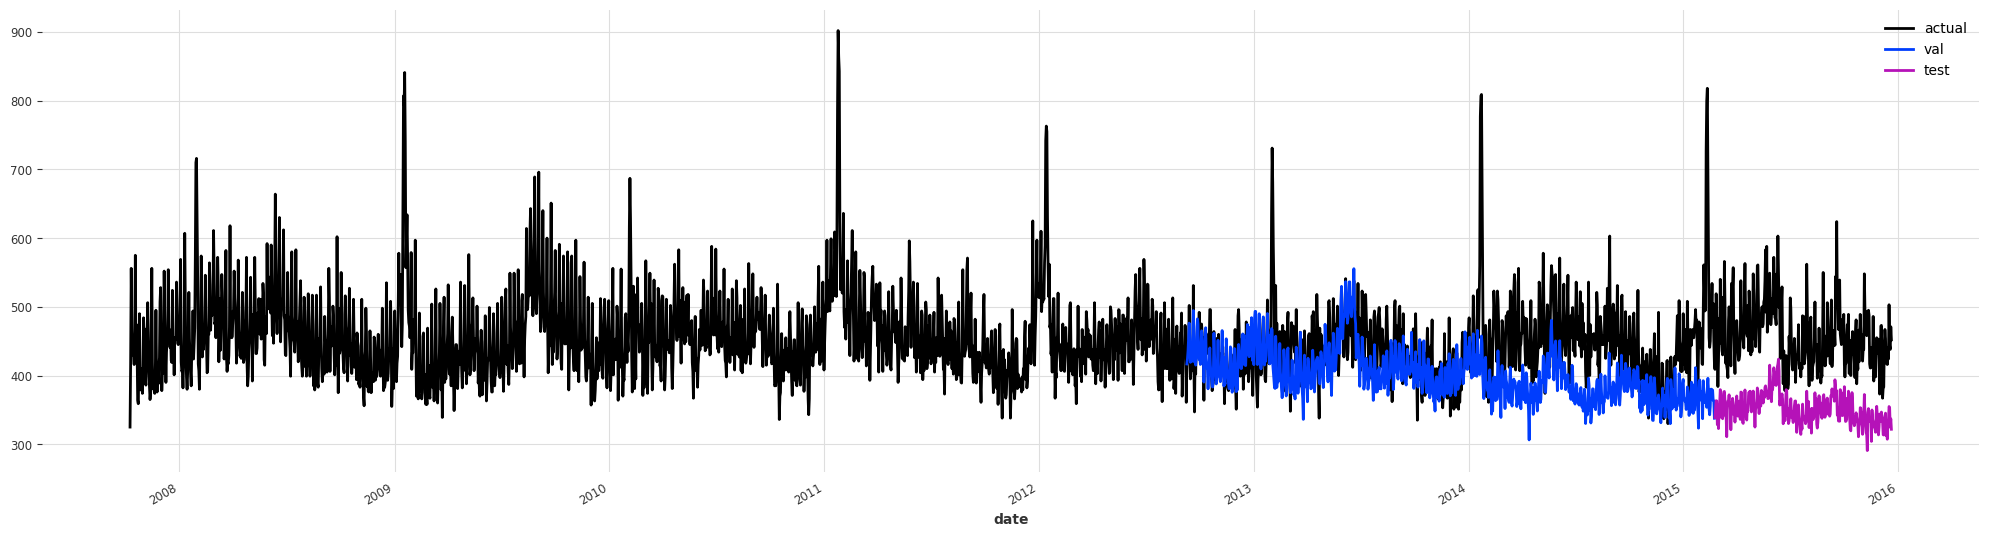

In [ ]:
plt.figure(figsize=(25, 6))
series.plot(label='actual')
Model_prediction_val.plot(label='val')
Model_prediction_test.plot(label='test')
#TiDEModel_prediction.plot(label='forecast', lw=1)

plt.legend()
plt.show()